In [1]:
# Ingoring Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sklearn
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn import tree
from sklearn import metrics

In [4]:
# Modifying plot properties

In [5]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':800})
sns.set_context('notebook')
sns.set_style("darkgrid")

# Loading Datasets and Exploratory Data analysis

In [6]:
tele_df = pd.read_csv("PdM_telemetry.csv") # Telemetry Time Series Data 
err_df = pd.read_csv("PdM_errors.csv") # Error Data
fail_df = pd.read_csv("PdM_failures.csv") # Failure Data
mach_df = pd.read_csv("PdM_machines.csv") # Metadata of Machines
main_df = pd.read_csv("PdM_maint.csv") # Maintenance Data

In [7]:
# First five rows of the dataframe
tele_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [8]:
err_df.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [9]:
fail_df.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [10]:
mach_df.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [11]:
main_df.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


# Telemetry Time Series Data

In [12]:
# Shape of the dataframe
tele_df.shape

(876100, 6)

In [13]:
# Information about columns and their datatypes
tele_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [14]:
# Converting datatime column from object datatype to datetime datatype
tables = [tele_df, main_df, fail_df, err_df]
for df in tables:
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)

In [15]:
tele_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   876100 non-null  datetime64[ns]
 1   machineID  876100 non-null  int64         
 2   volt       876100 non-null  float64       
 3   rotate     876100 non-null  float64       
 4   pressure   876100 non-null  float64       
 5   vibration  876100 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 40.1 MB


In [16]:
# Statistical summary of the telemetry time series data using describe method
tele_df.describe(datetime_is_numeric= True)

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


In [17]:
# Let's see how many machines are there using machineID column and nunique() function
print("No. of unique machines: {}".format(tele_df.machineID.nunique()))

No. of unique machines: 100


In [18]:
# What about number of observations for each machine?
tele_df.machineID.value_counts()

1      8761
64     8761
74     8761
73     8761
72     8761
       ... 
31     8761
30     8761
29     8761
28     8761
100    8761
Name: machineID, Length: 100, dtype: int64

In [19]:
# Are there any dates missing in the datetime column? ---> We can get the missing time data using date_range function 
pd.date_range(start="2015-01-01 06:00:00", end="2016-01-01 06:00:00", freq= 'H').difference(tele_df["datetime"])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [20]:
# Check if there are any duplicate rows
tele_df.duplicated().sum()

0

In [21]:
# Check if there are any null values in any column
tele_df.isna().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [22]:
tele_df[tele_df.machineID == 1][["datetime", "vibration"]]

,datetime,vibration
0,2015-01-01 06:00:00,45.087686
100,2015-01-01 07:00:00,43.413973
200,2015-01-01 08:00:00,34.178847
300,2015-01-01 09:00:00,41.122144
400,2015-01-01 10:00:00,25.990511
...,...,...
875600,2016-01-01 02:00:00,43.698137
875700,2016-01-01 03:00:00,42.111661
875800,2016-01-01 04:00:00,33.293572
875900,2016-01-01 05:00:00,46.609515


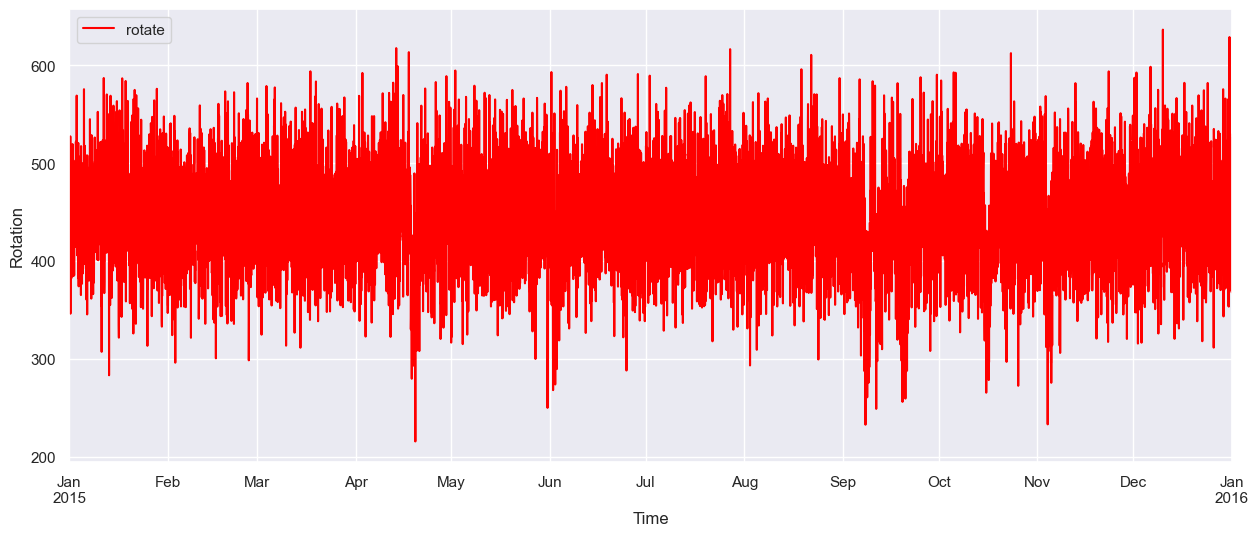

In [72]:
# Ploting how the Rotation values of machineID=1 are varying along the time period (1st jan 2015 to 1st jan 2016)
vib_mach_1 = tele_df[tele_df.machineID == 1][["datetime", "rotate"]].set_index("datetime")
vib_mach_1.plot(figsize=(15,6), color = 'red')
plt.xlim('2015-01', '2016-01')
plt.xlabel("Time")
plt.ylabel("Rotation")
#plt.savefig('Rotation_Mach_1.JPG',dpi=800,bbox_inches='tight')
plt.show();

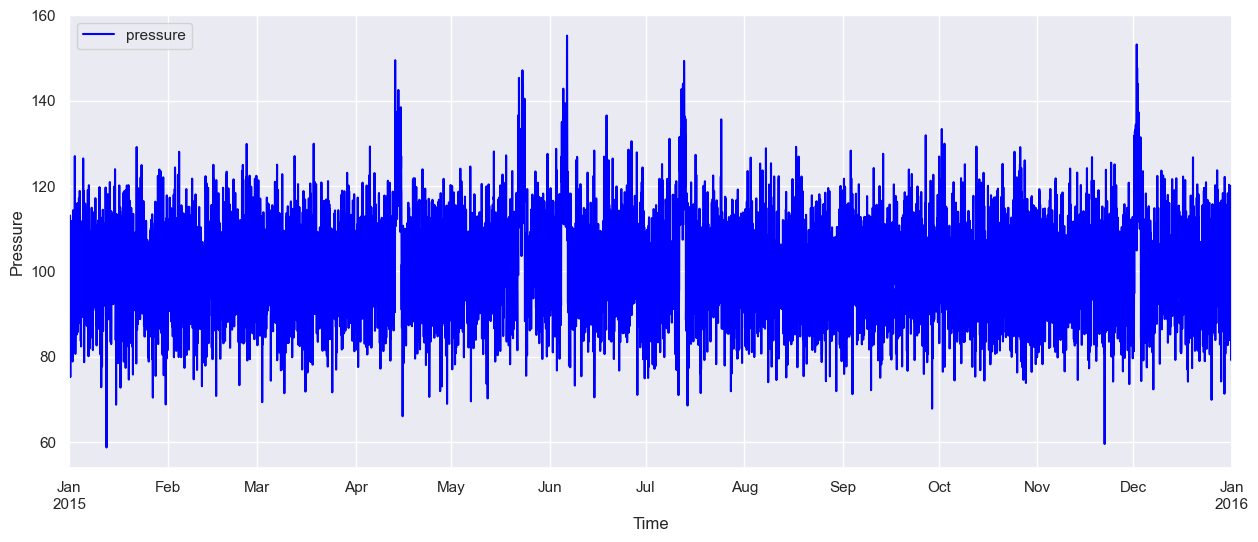

In [73]:
# Ploting how the pressure values of machineID=1 are varying along the time period (1st jan 2015 to 1st jan 2016)
vib_mach_1 = tele_df[tele_df.machineID == 1][["datetime", "pressure"]].set_index("datetime")
vib_mach_1.plot(figsize=(15,6), color = 'blue')
plt.xlim('2015-01', '2016-01')
plt.xlabel("Time")
plt.ylabel("Pressure")
#plt.savefig('Pressure_Mach_1.JPG',dpi=800,bbox_inches='tight')
plt.show();

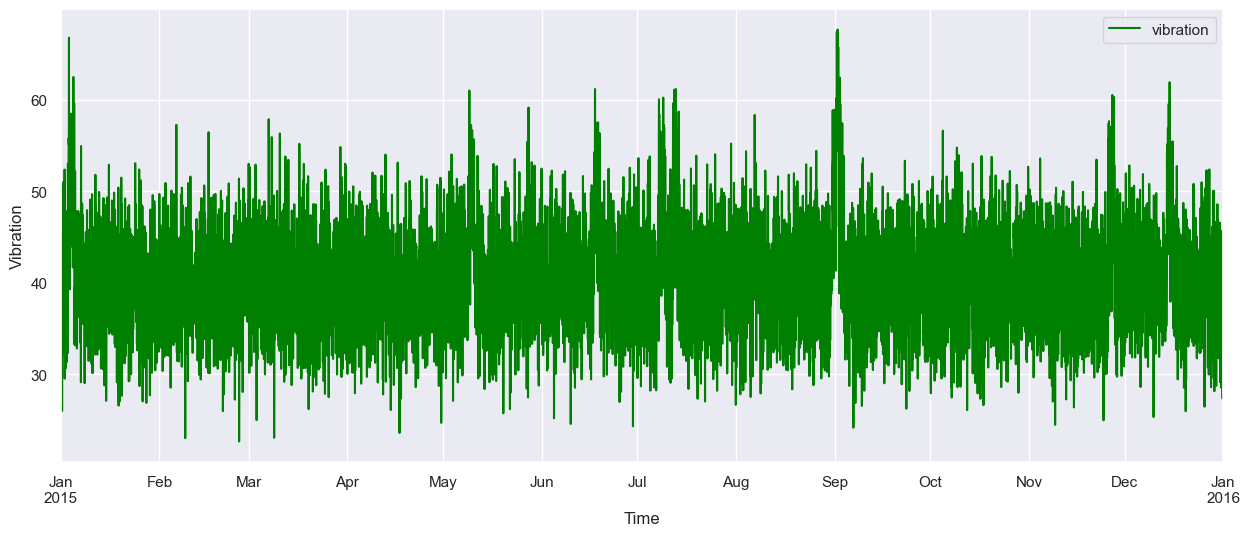

In [74]:
# Ploting how the vibration values of machineID=1 are varying along the time period (1st jan 2015 to 1st jan 2016)
vib_mach_1 = tele_df[tele_df.machineID == 1][["datetime", "vibration"]].set_index("datetime")
vib_mach_1.plot(figsize=(15,6), color = 'green')
plt.xlim('2015-01', '2016-01')
plt.xlabel("Time")
plt.ylabel("Vibration")
#plt.savefig('Vib_Mach_1.JPG',dpi=800,bbox_inches='tight')
plt.show();

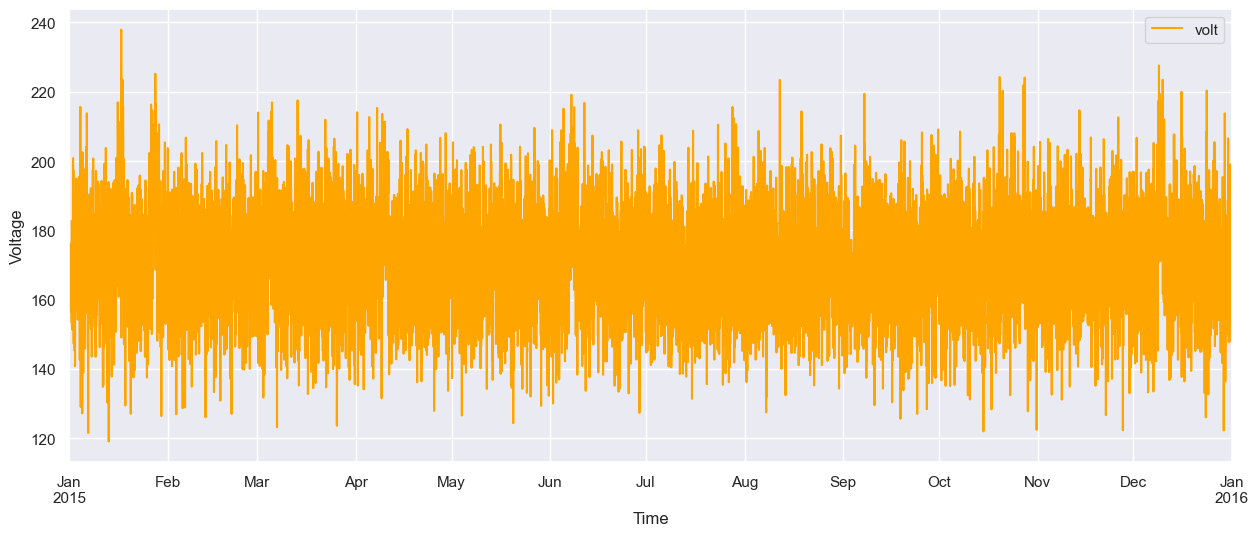

In [75]:
# Ploting how the voltage values of machineID=1 are varying along the time period (1st jan 2015 to 1st jan 2016)
vol_mach_1 = tele_df[tele_df.machineID == 1][["datetime", "volt"]].set_index("datetime")
vol_mach_1.plot(figsize=(15, 6), color = 'orange')
plt.xlim('2015-01', '2016-01')
plt.xlabel("Time")
plt.ylabel("Voltage")
#plt.savefig('Vol_Mach_1.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Error Data

In [27]:
err_df.head()

,datetime,machineID,errorID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4


In [28]:
err_df.shape

(3919, 3)

In [29]:
err_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   3919 non-null   datetime64[ns]
 1   machineID  3919 non-null   int64         
 2   errorID    3919 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 92.0+ KB


In [30]:
err_df.describe(datetime_is_numeric=True)

,datetime,machineID
count,3919,3919.000000
mean,2015-07-01 03:34:18.586373888,51.044654
min,2015-01-01 06:00:00,1.000000
25%,2015-03-31 05:00:00,25.000000
50%,2015-07-01 06:00:00,51.000000
75%,2015-10-01 15:00:00,77.000000
max,2016-01-01 05:00:00,100.000000
std,NaN,28.954988


In [31]:
err_df.duplicated().sum()

0

In [32]:
err_df.isna().sum()

datetime     0
machineID    0
errorID      0
dtype: int64

In [33]:
err_df.errorID.value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

<AxesSubplot:title={'center':'Types of Errors'}>

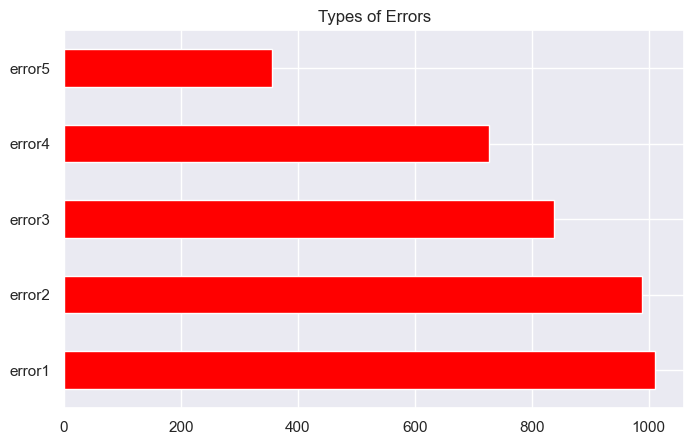

In [34]:
# What can be the different types of errors encountered by the machines
type_err = err_df['errorID'].value_counts()
type_err.plot(kind='barh', figsize=(8,5), grid=True, title= 'Types of Errors', color = 'red')
#plt.savefig('Type_of_errors.JPG',dpi=800,bbox_inches='tight');

Text(0, 0.5, 'Number of Errors')

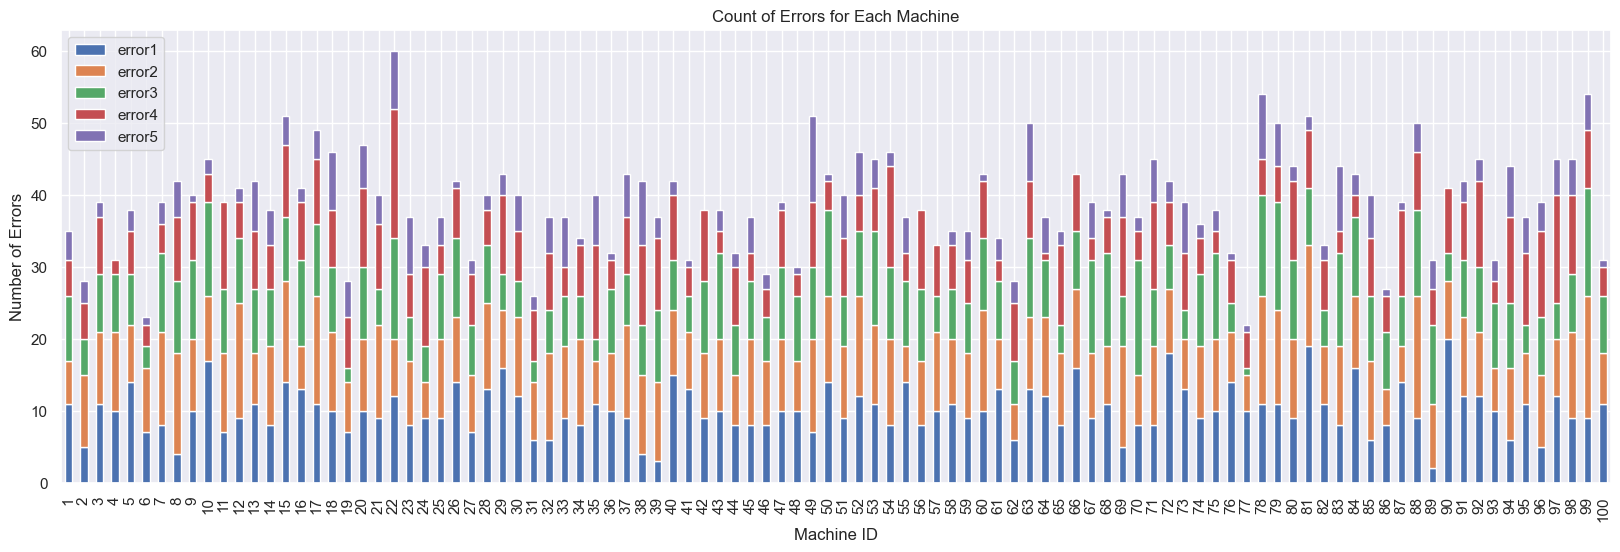

In [35]:
# A machine may have encountered zero or one or multiple errors right? The below plot reveals what are the different types of errors encountered by each machine using stacked barplot
count_err = err_df.groupby(["machineID", "errorID"]).size().reset_index()
count_err.columns = ["machineID", "errorID", "errorValues"]
count_err_pivot = pd.pivot(count_err, index="machineID", columns="errorID", values="errorValues").rename_axis(None, axis=1)
count_err_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Errors for Each Machine")
plt.xlabel("Machine ID")
plt.ylabel("Number of Errors")
#plt.savefig('Type_of_errors_stacked.JPG',dpi=800,bbox_inches='tight');

# Manitenance Data

In [36]:
main_df.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-06-01 06:00:00,6,comp2
2,2014-06-01 06:00:00,9,comp1
3,2014-06-01 06:00:00,9,comp2
4,2014-06-01 06:00:00,11,comp2


In [37]:
main_df['datetime'].describe()

count                    3286
unique                    374
top       2014-11-28 06:00:00
freq                       37
first     2014-06-01 06:00:00
last      2016-01-01 06:00:00
Name: datetime, dtype: object

In [38]:
main_df.shape

(3286, 3)

In [39]:
main_df.duplicated().sum()

0

In [40]:
main_df.isna().sum()

datetime     0
machineID    0
comp         0
dtype: int64

In [41]:
main_df.comp.value_counts()

comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

<AxesSubplot:title={'center':'Types of components replaced'}>

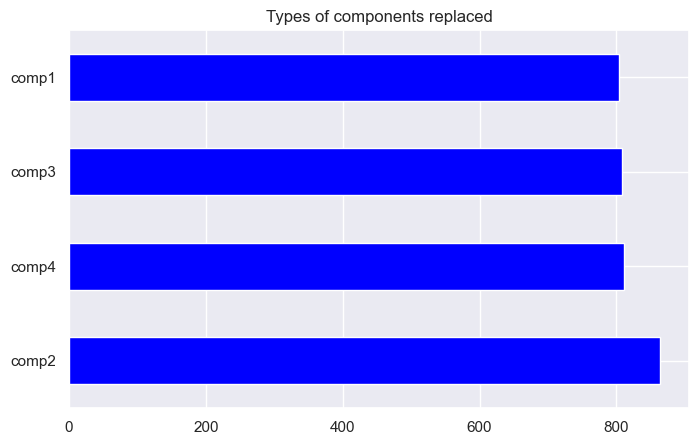

In [42]:
# What are the different types of components that have been replaced for the machines?
type_comp = main_df.comp.value_counts()
type_comp.plot(kind = 'barh', figsize=(8,5), grid=True, title= 'Types of components replaced', color = 'blue')
#plt.savefig('Type_of_components_replaced.JPG',dpi=800,bbox_inches='tight');

Text(0, 0.5, 'Number of Components Replaced')

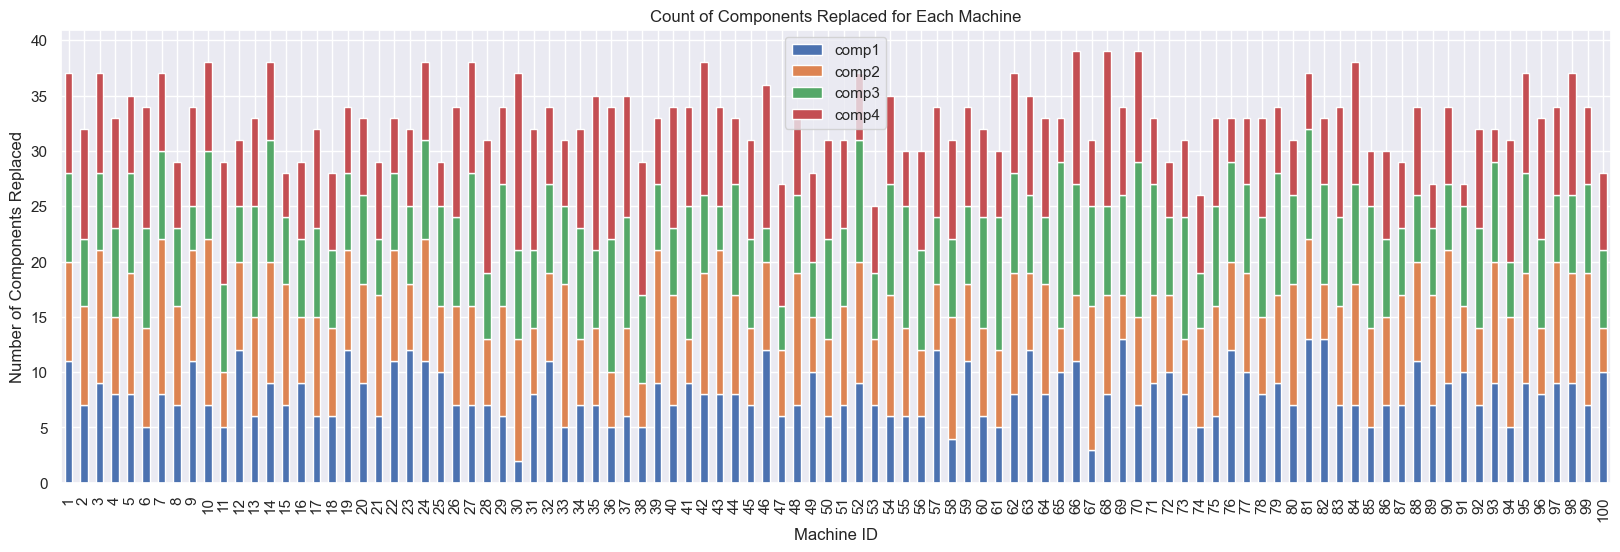

In [43]:
# What are the components that are replaced for each machine?
count_main_df = main_df.groupby(["machineID", "comp"]).size().reset_index()
count_main_df.columns = ["machineID", "comp", "num_comp"]
count_main_df_pivot = pd.pivot(count_main_df, index="machineID", columns="comp", values="num_comp").rename_axis(None, axis=1)
count_main_df_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Components Replaced for Each Machine")
plt.xlabel("Machine ID")
plt.ylabel("Number of Components Replaced")
#plt.savefig('Type_of_components_replaced_stacked.JPG',dpi=800,bbox_inches='tight');

# Failure Data

In [44]:
fail_df.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


In [45]:
fail_df.shape

(761, 3)

In [46]:
fail_df.failure.value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

<AxesSubplot:title={'center':'Components Replaced due to failure'}>

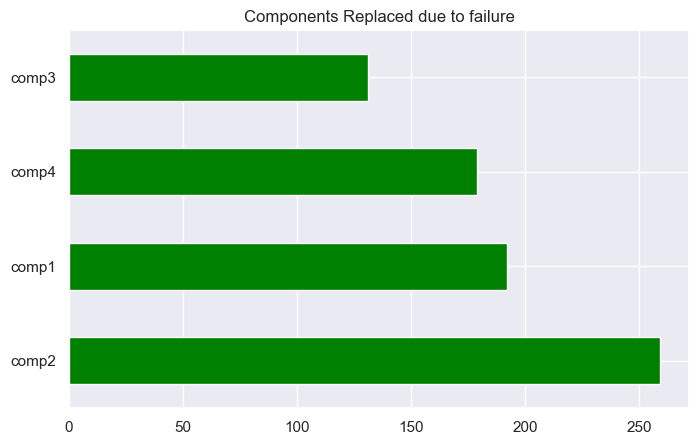

In [47]:
# What are the overall components replaced after failure of the machines?
type_comp1 = fail_df.failure.value_counts()
type_comp1.plot(kind = 'barh', figsize=(8,5), grid=True, title= 'Components Replaced due to failure', color = 'green')
#plt.savefig('Components_Replaced_due_to_failure.JPG',dpi=800,bbox_inches='tight');

# Machines Data

In [48]:
mach_df.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [49]:
mach_df.shape

(100, 3)

In [50]:
mach_df.duplicated().sum()

0

In [51]:
mach_df.isna().sum()

machineID    0
model        0
age          0
dtype: int64

In [52]:
mach_df.age.value_counts()

14    14
10    10
20     7
17     7
18     6
2      6
15     6
7      6
16     5
9      5
5      4
19     4
6      4
3      4
4      3
1      3
11     2
12     2
0      1
8      1
Name: age, dtype: int64

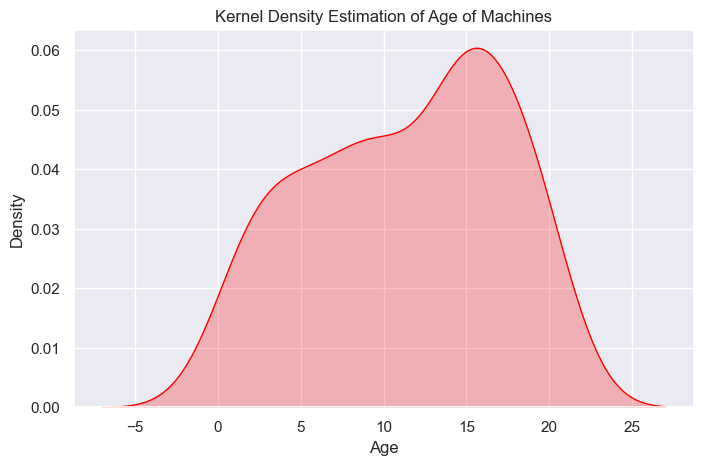

In [53]:
# How the Distribution curve for the age of the machines look like?
plt.figure(figsize=(8, 5))
sns.kdeplot(mach_df['age'], color='red', shade=True, shade_lowest=False)
plt.grid(True)
plt.title('Kernel Density Estimation of Age of Machines')
plt.xlabel('Age')
plt.ylabel('Density')
#plt.savefig('Mach_Age_KDE.JPG', dpi=800, bbox_inches='tight')
plt.show();

In [54]:
# Let's merge the Telemetry Data and Machines Data

In [55]:
tele_mach_df = tele_df.merge(right = mach_df, on = 'machineID', how = 'left')
tele_mach_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2


In [56]:
tele_mach_df.shape

(876100, 8)

In [57]:
tele_mach_df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
model        0
age          0
dtype: int64

In [58]:
# Now merge Error Data

In [59]:
tele_mach_err_df = tele_mach_df.merge(right = err_df, on = ['datetime', 'machineID'], how = 'left')

In [60]:
tele_mach_err_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,NaN
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,NaN
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,NaN
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,NaN


In [61]:
tele_mach_err_df.shape

(876403, 9)

In [62]:
tele_mach_err_df.errorID.value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

In [63]:
tele_mach_err_df.isnull().sum()

datetime          0
machineID         0
volt              0
rotate            0
pressure          0
vibration         0
model             0
age               0
errorID      872484
dtype: int64

In [64]:
# If error column doesn't have any error and consist null values, that means there are machines that aren't encountered any errors. 
# So, we can fill these null values with No Error values.
# Let's replace those null values with No Error.
tele_mach_err_df['errorID'].fillna('No Error', inplace = True)
tele_mach_err_df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
model        0
age          0
errorID      0
dtype: int64

In [65]:
tele_mach_err_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,No Error
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,No Error
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,No Error
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,No Error
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,No Error


In [66]:
tele_mach_err_df.errorID.value_counts()

No Error    872484
error1        1010
error2         988
error3         838
error4         727
error5         356
Name: errorID, dtype: int64

In [113]:
# What happens if we merge Maintenance Data also?

In [114]:
tele_mach_err_main_df = tele_mach_err_df.merge(right = main_df, on = ['datetime', 'machineID'], how = 'left')
tele_mach_err_main_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,No Error,NaN
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,No Error,NaN
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,No Error,NaN
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,No Error,NaN
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,No Error,NaN


In [115]:
tele_mach_err_main_df.comp.value_counts()

comp2    763
comp4    711
comp3    708
comp1    704
Name: comp, dtype: int64

In [116]:
tele_mach_err_main_df.isnull().sum()

datetime          0
machineID         0
volt              0
rotate            0
pressure          0
vibration         0
model             0
age               0
errorID           0
comp         874240
dtype: int64

In [117]:
# Here also we can observe some values in the components replaced column are null, that means some machines, any component is been replaced. 
# This explains that, those machine aren't subjected to any failure. 
# Let's replace those null values with No Failure.
tele_mach_err_main_df['comp'].fillna('No Failure', inplace = True)
tele_mach_err_main_df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
model        0
age          0
errorID      0
comp         0
dtype: int64

In [118]:
tele_mach_err_main_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,No Error,No Failure
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,No Error,No Failure
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,No Error,No Failure
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,No Error,No Failure
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,No Error,No Failure


In [119]:
tele_mach_err_main_df.shape

(877126, 10)

In [120]:
tele_mach_err_main_df.comp.value_counts()

No Failure    874240
comp2            763
comp4            711
comp3            708
comp1            704
Name: comp, dtype: int64

In [121]:
# Why don't we merge the Failure Data which is a subset of maintenance data

In [122]:
tele_mach_err_main_fail_df = tele_mach_err_main_df.merge(right = fail_df, on = ['datetime', 'machineID'], how ='left')

In [123]:
tele_mach_err_main_fail_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,No Error,No Failure,NaN
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,No Error,No Failure,NaN
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,No Error,No Failure,NaN
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,No Error,No Failure,NaN
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,No Error,No Failure,NaN


In [124]:
tele_mach_err_main_fail_df.failure.value_counts()

comp2    386
comp1    291
comp4    255
comp3    190
Name: failure, dtype: int64

In [125]:
tele_mach_err_main_fail_df.isnull().sum()

datetime          0
machineID         0
volt              0
rotate            0
pressure          0
vibration         0
model             0
age               0
errorID           0
comp              0
failure      876087
dtype: int64

In [126]:
# "Wow, here we can also see null values in the Failure column. This indicates that some machines didn't fail."
# "The machines that underwent component replacement show that those machines have failed."

In [127]:
# Let's replace those null values with No Failure.
tele_mach_err_main_fail_df['failure'].fillna('No Failure', inplace = True)
tele_mach_err_main_fail_df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
model        0
age          0
errorID      0
comp         0
failure      0
dtype: int64

In [128]:
tele_mach_err_main_fail_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,No Error,No Failure,No Failure
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,No Error,No Failure,No Failure
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,No Error,No Failure,No Failure
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,No Error,No Failure,No Failure
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,No Error,No Failure,No Failure


In [129]:
tele_mach_err_main_fail_df.shape

(877209, 11)

In [130]:
tele_mach_err_main_fail_df.failure.value_counts()

No Failure    876087
comp2            386
comp1            291
comp4            255
comp3            190
Name: failure, dtype: int64

In [131]:
df = tele_mach_err_main_fail_df
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,No Error,No Failure,No Failure
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,model4,7,No Error,No Failure,No Failure
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,model3,8,No Error,No Failure,No Failure
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,model3,7,No Error,No Failure,No Failure
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,model3,2,No Error,No Failure,No Failure


In [132]:
df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
model        0
age          0
errorID      0
comp         0
failure      0
dtype: int64

In [133]:
df.isna().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
model        0
age          0
errorID      0
comp         0
failure      0
dtype: int64

In [134]:
df.duplicated().sum()

0

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877209 entries, 0 to 877208
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   877209 non-null  datetime64[ns]
 1   machineID  877209 non-null  int64         
 2   volt       877209 non-null  float64       
 3   rotate     877209 non-null  float64       
 4   pressure   877209 non-null  float64       
 5   vibration  877209 non-null  float64       
 6   model      877209 non-null  object        
 7   age        877209 non-null  int64         
 8   errorID    877209 non-null  object        
 9   comp       877209 non-null  object        
 10  failure    877209 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 80.3+ MB


In [136]:
df.errorID.value_counts()

No Error    873285
error1        1013
error2         988
error3         838
error4         728
error5         357
Name: errorID, dtype: int64

In [137]:
df.model.value_counts()

model3    307013
model4    280699
model2    149117
model1    140380
Name: model, dtype: int64

In [138]:
df.comp.value_counts()

No Failure    874241
comp2            790
comp4            735
comp1            723
comp3            720
Name: comp, dtype: int64

In [139]:
df.failure.value_counts()

No Failure    876087
comp2            386
comp1            291
comp4            255
comp3            190
Name: failure, dtype: int64

# Encoding the categorical variables

In [140]:
from sklearn.preprocessing import LabelEncoder
# Here the categorical variables are failure, model, errorID, comp
categorical_columns = ['failure', 'model', 'errorID', 'comp']
label_encoders = {}
for i in categorical_columns:
    label_encoder = LabelEncoder()
    df[i] = label_encoder.fit_transform(df[i])
    label_encoders[i] = label_encoder

df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0


In [141]:
# Let's create our target feature (Failure Status) based on failure column: component replacement --> Failure (1), No failure --> No Failure (0)
df['Failure_Status'] = df['failure'].apply(lambda x : 0 if x == 0 else 1)
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,Failure_Status
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,0
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,0
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,0
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,0
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,0


In [142]:
df.Failure_Status.value_counts()

0    876087
1      1122
Name: Failure_Status, dtype: int64

In [143]:
# From the number of catergorical values, it indicates a heavy imbalance in the data 

In [144]:
# Using to_datetime function in pandas, new columns (year, month, day, hour) can be created based on datetime column.
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['day'] = pd.to_datetime(df['datetime']).dt.day
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

In [145]:
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,Failure_Status,year,month,day,hour
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,0,2015,1,1,6
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,0,2015,1,1,6
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,0,2015,1,1,6
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,0,2015,1,1,6
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,0,2015,1,1,6


In [146]:
# Similarly, 'day of week' and 'day of year' columns can be extracted.
df['day_of_week'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['day_of_year'] = pd.to_datetime(df['datetime']).dt.dayofyear

In [147]:
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,Failure_Status,year,month,day,hour,day_of_week,day_of_year
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,0,2015,1,1,6,3,1
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,0,2015,1,1,6,3,1
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,0,2015,1,1,6,3,1
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,0,2015,1,1,6,3,1
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,0,2015,1,1,6,3,1


In [149]:
# A 'time of day' (whether it is morning or afternoon or evening or night) can be created like this:
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"

df['time_of_day'] = df['hour'].apply(categorize_time_of_day)

In [150]:
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,Failure_Status,year,month,day,hour,day_of_week,day_of_year,time_of_day
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,0,2015,1,1,6,3,1,morning
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,0,2015,1,1,6,3,1,morning
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,0,2015,1,1,6,3,1,morning
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,0,2015,1,1,6,3,1,morning
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,0,2015,1,1,6,3,1,morning


In [151]:
# A 'season' (whether it is spring or summer or fall or winter) column can be created like this:
def categorize_season(month):
    if 3 <= month <= 5:
        return "spring"
    elif 6 <= month <= 8:
        return "summer"
    elif 9 <= month <= 11:
        return "fall"
    else:
        return "winter"

df['season'] = df['month'].apply(categorize_season)

In [152]:
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,Failure_Status,year,month,day,hour,day_of_week,day_of_year,time_of_day,season
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,0,2015,1,1,6,3,1,morning,winter
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,0,2015,1,1,6,3,1,morning,winter
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,0,2015,1,1,6,3,1,morning,winter
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,0,2015,1,1,6,3,1,morning,winter
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,0,2015,1,1,6,3,1,morning,winter


In [153]:
df.season.value_counts()

summer    221108
spring    221075
fall      218680
winter    216346
Name: season, dtype: int64

In [155]:
# This is an interesting column, 'is weekend' (Is it weekend or week day) column can be extracted from 
# the 'day of week' column in this way
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [156]:
df.is_weekend.value_counts()

0    627296
1    249913
Name: is_weekend, dtype: int64

In [157]:
# Let's create a new column, that is 'time since start'. This shows how many hours the machine is in operation.
df['datetime'] = pd.to_datetime(df['datetime'])

df['time_since_start'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() / 3600


df.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,...,year,month,day,hour,day_of_week,day_of_year,time_of_day,season,is_weekend,time_since_start
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0


In [158]:
df.time_since_start.value_counts()

7704.0    113
5496.0    111
432.0     111
6096.0    111
720.0     110
         ... 
2966.0    100
2965.0    100
2964.0    100
2963.0    100
8760.0    100
Name: time_since_start, Length: 8761, dtype: int64

In [159]:
df.duplicated().sum()

0

In [160]:
# After extracting the date features from the datetime column, we can drop datetime column, 
# because now the dataframe consists of features of datetime separately.
df = df.drop(['datetime'], axis = 1)

In [163]:
df.head()

,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,...,year,month,day,hour,day_of_week,day_of_year,time_of_day,season,is_weekend,time_since_start
0,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
1,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
2,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
3,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0
4,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,...,2015,1,1,6,3,1,morning,winter,0,0.0


In [164]:
df.year.describe()

count    877209.000000
mean       2015.000798
std           0.028237
min        2015.000000
25%        2015.000000
50%        2015.000000
75%        2015.000000
max        2016.000000
Name: year, dtype: float64

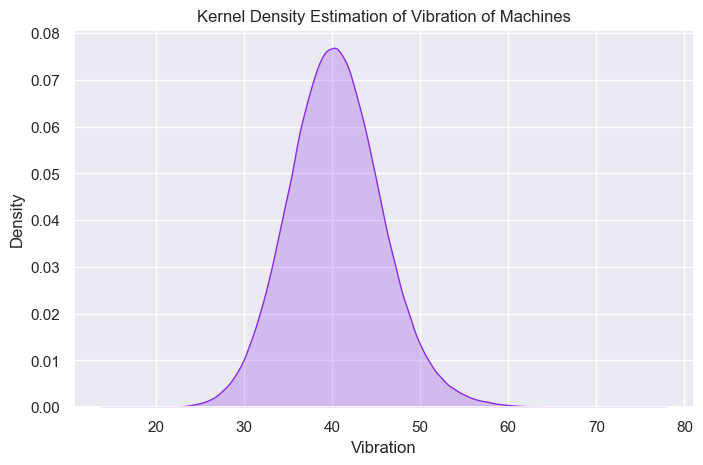

In [165]:
# How does the distribution of vibration column through out the data look like?
plt.figure(figsize=(8, 5))
sns.kdeplot(df['vibration'], color='blueviolet', shade=True, shade_lowest=False)
plt.grid(True)
plt.title('Kernel Density Estimation of Vibration of Machines')
plt.xlabel('Vibration')
plt.ylabel('Density')
#plt.savefig('vibration_KDE.JPG', dpi=800, bbox_inches='tight')
plt.show();

In [166]:
# List of colors in matplotlib
import matplotlib.colors as mcolors
named_colors = list(mcolors.CSS4_COLORS.keys())
print(named_colors)

['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 

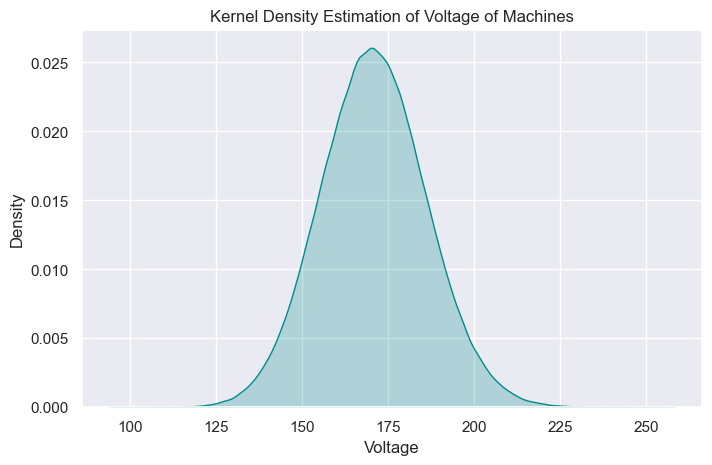

In [167]:
# How does the distribution of votage column through out the data look like?
plt.figure(figsize=(8, 5))
sns.kdeplot(df['volt'], color='darkcyan', shade=True, shade_lowest=False)
plt.grid(True)
plt.title('Kernel Density Estimation of Voltage of Machines')
plt.xlabel('Voltage')
plt.ylabel('Density')
#plt.savefig('volt_KDE.JPG', dpi=800, bbox_inches='tight')
plt.show();

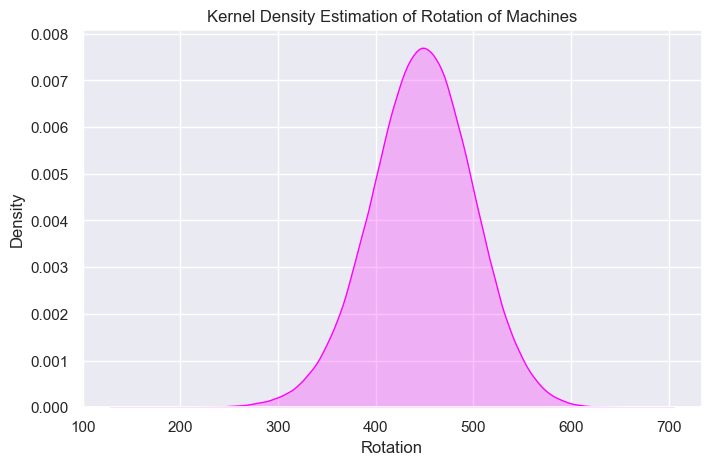

In [168]:
# How does the distribution of rotate column through out the data look like?
plt.figure(figsize=(8, 5))
sns.kdeplot(df['rotate'], color='magenta', shade=True, shade_lowest=False)
plt.grid(True)
plt.title('Kernel Density Estimation of Rotation of Machines')
plt.xlabel('Rotation')
plt.ylabel('Density')
#plt.savefig('rotate_KDE.JPG', dpi=800, bbox_inches='tight')
plt.show();

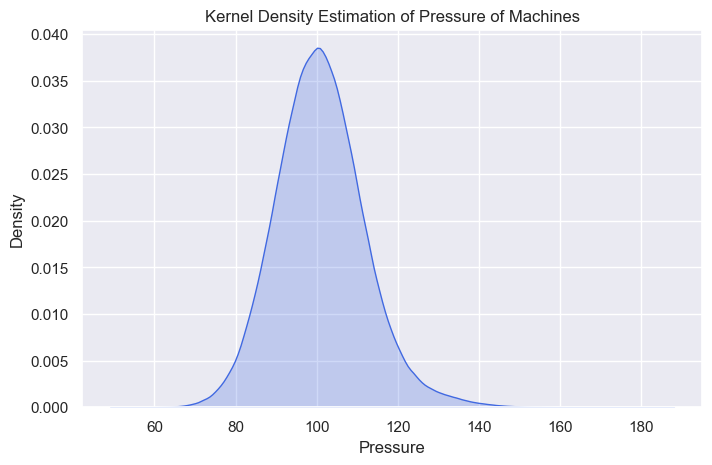

In [169]:
# How does the distribution of pressure column through out the data look like?
plt.figure(figsize=(8, 5))
sns.kdeplot(df['pressure'], color='royalblue', shade=True, shade_lowest=False)
plt.grid(True)
plt.title('Kernel Density Estimation of Pressure of Machines')
plt.xlabel('Pressure')
plt.ylabel('Density')
#plt.savefig('Pressure_KDE.JPG', dpi=800, bbox_inches='tight')
plt.show();

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877209 entries, 0 to 877208
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   machineID         877209 non-null  int64  
 1   volt              877209 non-null  float64
 2   rotate            877209 non-null  float64
 3   pressure          877209 non-null  float64
 4   vibration         877209 non-null  float64
 5   model             877209 non-null  int32  
 6   age               877209 non-null  int64  
 7   errorID           877209 non-null  int32  
 8   comp              877209 non-null  int32  
 9   failure           877209 non-null  int32  
 10  Failure_Status    877209 non-null  int64  
 11  year              877209 non-null  int64  
 12  month             877209 non-null  int64  
 13  day               877209 non-null  int64  
 14  hour              877209 non-null  int64  
 15  day_of_week       877209 non-null  int64  
 16  day_of_year       87

In [171]:
# If you observe carefully, 'time of day' and 'season' columns have categorical values. 
# Let's encode them in this way:
categorical_columns = ['time_of_day', 'season']
label_encoders = {}
for i in categorical_columns:
    label_encoder = LabelEncoder()
    df[i] = label_encoder.fit_transform(df[i])
    label_encoders[i] = label_encoder

df.head()

,machineID,volt,rotate,pressure,vibration,model,age,errorID,comp,failure,...,year,month,day,hour,day_of_week,day_of_year,time_of_day,season,is_weekend,time_since_start
0,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0,0,...,2015,1,1,6,3,1,2,3,0,0.0
1,2,176.558913,424.624162,76.005332,43.767049,3,7,0,0,0,...,2015,1,1,6,3,1,2,3,0,0.0
2,3,185.482043,461.211137,87.453199,28.216864,2,8,0,0,0,...,2015,1,1,6,3,1,2,3,0,0.0
3,4,169.710847,463.646727,95.929877,38.400372,2,7,0,0,0,...,2015,1,1,6,3,1,2,3,0,0.0
4,5,165.082899,452.283576,84.591722,40.298803,2,2,0,0,0,...,2015,1,1,6,3,1,2,3,0,0.0


In [172]:
df.Failure_Status.value_counts()

0    876087
1      1122
Name: Failure_Status, dtype: int64

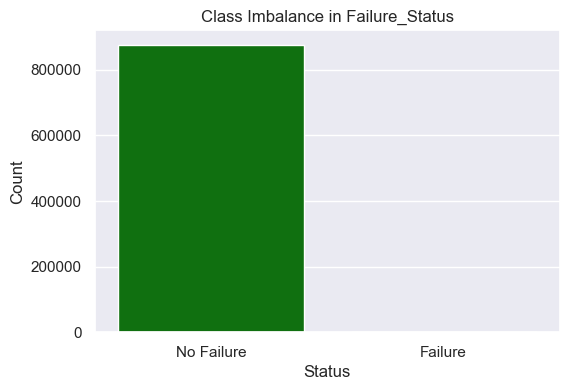

In [179]:
ax = sns.countplot(x='Failure_Status', data=df, palette={0: 'green', 1: 'red'})

ax.set_xticklabels(['No Failure', 'Failure'])

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Class Imbalance in Failure_Status')
plt.show();

# Feature Engineering

In [ ]:
g=sns.pairplot(df, diag_kind="kde", palette = 'Spectral', hue='Failure_Status')#, height=3)
g.map_lower(sns.scatterplot)

g.add_legend()

plt.show();

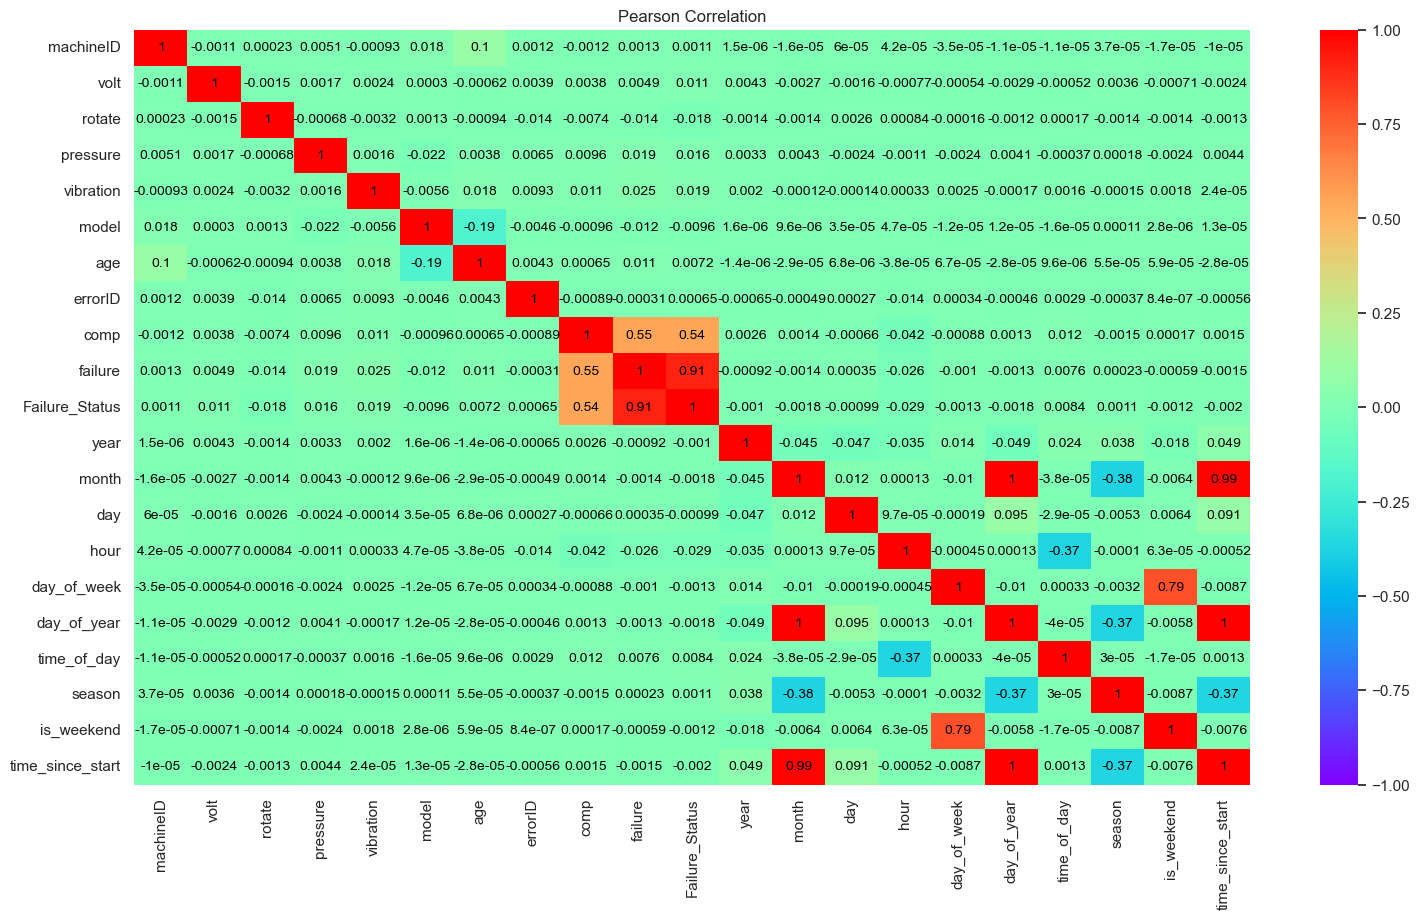

In [182]:
# Pearson Correlation Matrix plot:
plt.figure(figsize=(18,10))
dataplot = sns.heatmap(df.corr(), cmap = 'rainbow', annot = True, vmin = -1, vmax = 1, annot_kws= {'color': 'black', 'fontsize': 10})
plt.title('Pearson Correlation')
#plt.savefig('Initial_Pearson.JPG',dpi=800,bbox_inches='tight');

In [183]:
# The features ('month', 'day_of_year', 'day_of_week', 'failure') are having high correlation and has to be removed.
df = df.drop(['month', 'day_of_year', 'day_of_week', 'failure'], axis = 1)
df.shape

(877209, 17)

Text(0.5, 1.0, 'Pearson Correlation')

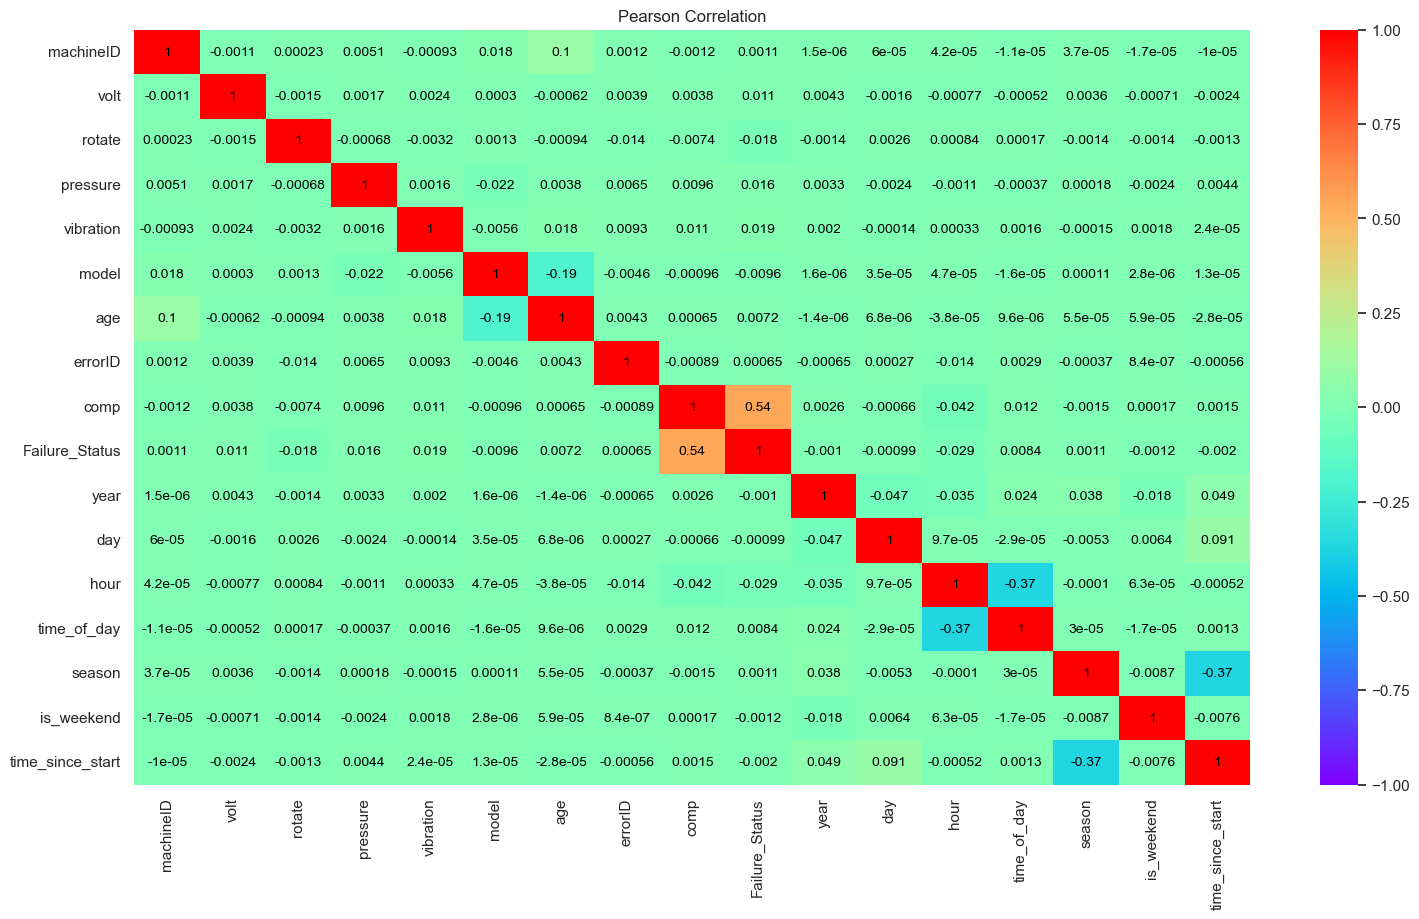

In [184]:
# After the removel of highly correlated features, now the Pearson Correlation Matrix looks like:
plt.figure(figsize=(18,10))
dataplot = sns.heatmap(df.corr(), cmap = 'rainbow', annot = True, vmin = -1, vmax = 1, annot_kws= {'color': 'black', 'fontsize': 10})
plt.title('Pearson Correlation')
#plt.savefig('Final_Pearson.JPG',dpi=800,bbox_inches='tight');

In [185]:
# Assigning predictors/independent features to 'X' variable, and target/dependent feature to 'Y' varible.
X = df.drop(['Failure_Status'], axis = 1)
y = df[["Failure_Status"]]

# Splitting the Dataset

In [186]:
# Training dataset : Testing dataset = 67% : 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = df.Failure_Status)

In [187]:
# X_train.to_csv('X_train.csv')
# y_train.to_csv('y_train.csv')
# X_test.to_csv('X_test.csv')
# y_test.to_csv('y_test.csv')
# We can load the training and testing datasets using pandas.read_csv

In [192]:
Train_df = pd.concat([X_train, y_train], axis=1)
sample = Train_df[["pressure", 'vibration','Failure_Status']]
sample.head()

,pressure,vibration,Failure_Status
0,95.523899,43.244470,0
1,103.253230,49.889798,0
2,94.698942,40.873166,0
3,110.066778,31.060026,0
4,95.939133,38.357959,0


In [193]:
sample['Failure_Status'] = sample['Failure_Status'].replace({0: 'No Failure', 1: 'Failure'})

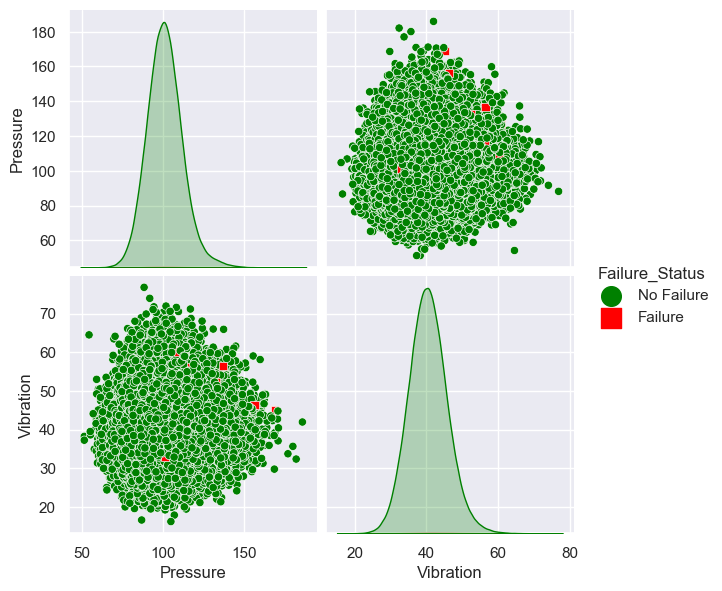

In [194]:
# Let's consider two features ('Pressure', 'vibration') and plot a pairplot between them and this plot visualizes 
# the distribution of 'Failure' and 'No failure' points.
s=sns.pairplot(sample, hue= "Failure_Status", height=3, palette=['green', 'red'], markers=["o", "s"], diag_kind="kde") 
replacement=({'pressure': 'Pressure', 'vibration':'Vibration'})
plt.rcParams['axes.labelweight'] = 'bold'  
plt.rcParams['axes.labelsize'] = 12
for i in range(2):
    for j in range(2):
        xlabel=s.axes[i][j].get_xlabel()
        ylabel=s.axes[i][j].get_ylabel()
        if xlabel in replacement.keys():
            s.axes[i][j].set_xlabel(replacement[xlabel])
        if ylabel in replacement.keys():
            s.axes[i][j].set_ylabel(replacement[ylabel])
for legend in s._legend.legendHandles:
    legend.set_alpha(1)
    legend._sizes=[200]
    
#plt.savefig('Distribution.JPG',dpi=800,bbox_inches='tight')

# Scaling the Dataset

In [195]:
# Scaling the dataset makes the ML model to learn faster, because all the features will come to a similar scale.
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# TRAINING THE MODELS

# Logistic Regression

In [197]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state =42, n_jobs = -1)
# Fitting the train data to the model/training the model on the train data.
lr.fit(X_train_sc, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [198]:
# Getting the predictions from the model and assigning them to a variable.
lr_pred = lr.predict(X_test_sc)

In [199]:
# Calculating the confusion matrix using Failure_Status values from the test data and from the model predictions
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, lr_pred)

In [201]:
# Function to plot a confusion matrix. (This can be ignored)
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_lr.JPG',dpi=1000,bbox_inches='tight')

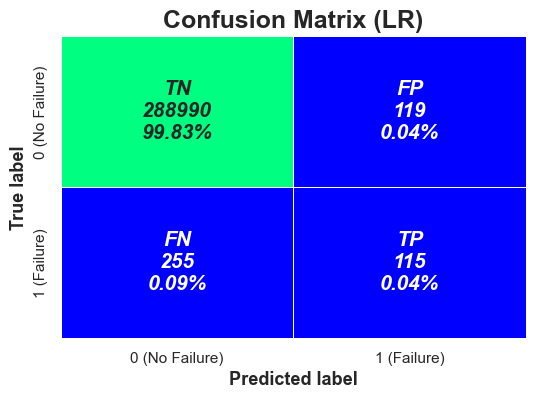

In [202]:
# After calculation of confusion matrix, using those values
# and let's call the above defined function (make_confusion_matrix)
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (LR)')

In [203]:
# Let's see the precision, recall, and f1-score for both the classes using classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, lr_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999118,0.999588,0.999353
1,0.491453,0.310811,0.380795
accuracy,0.998708,0.998708,0.998708
macro avg,0.745286,0.655200,0.690074


In [204]:
# Calculating F2-Score using fbeta_score
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, lr_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.33547257876312714


In [19]:
#styled_report_df.to_excel("report_lr.xlsx", index=False)

In [205]:
# Calculating probabilities for the predictions
from sklearn.metrics import precision_recall_curve, auc
lr_pred_prob = lr.predict_proba(X_test_sc)[:, 1]

In [206]:
# getting precision, recall values using precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_pred_prob)
auc_pr = auc(recall, precision)

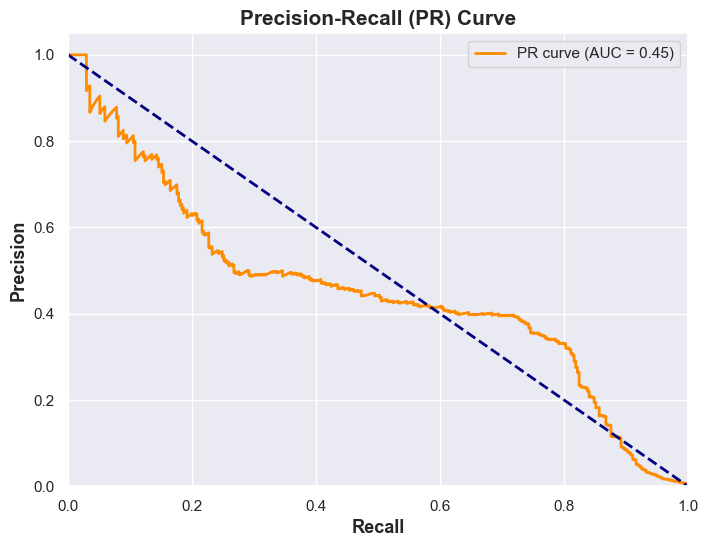

In [207]:
# Plotting Precision-Recall (PR) Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
#plt.savefig('PR_curve_lr.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Random Forest Classification

In [18]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train_sc, y_train)
rfc_pred = rfc.predict(X_test_sc)

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, rfc_pred)

In [27]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
   

       blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
      
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""



    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_rfc.JPG',dpi=1000,bbox_inches='tight')

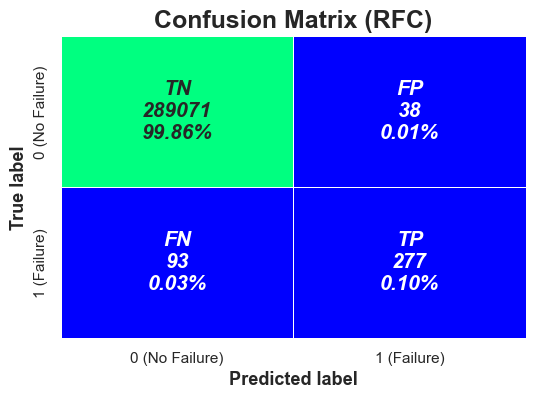

In [28]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (RFC)')

In [29]:
from sklearn.metrics import classification_report
report = classification_report(y_test, rfc_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999678,0.999869,0.999773
1,0.879365,0.748649,0.808759
accuracy,0.999547,0.999547,0.999547
macro avg,0.939522,0.874259,0.904266


In [19]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, rfc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.7715877437325905


In [30]:
styled_report_df.to_excel("report_rfc.xlsx", index=False)

In [31]:
from sklearn.metrics import precision_recall_curve, auc
rfc_pred_prob = rfc.predict_proba(X_test_sc)[:, 1]

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, rfc_pred_prob)
auc_pr = auc(recall, precision)

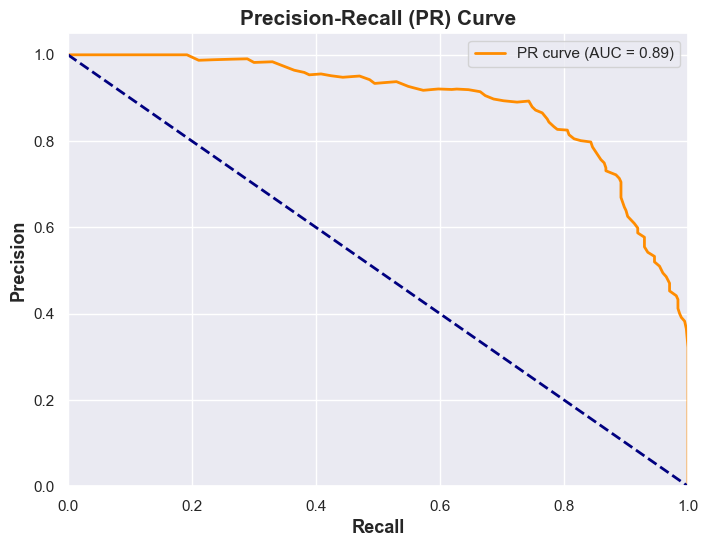

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
#plt.savefig('PR_curve_rfc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Decision Tree Classification

In [20]:
dtc = tree.DecisionTreeClassifier(random_state =42)
dtc.fit(X_train_sc, y_train)
dtc_pred = dtc.predict(X_test_sc)

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, dtc_pred)

In [49]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        
        accuracy  = np.trace(cf) / float(np.sum(cf))

    
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
    
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
    
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_dtc.JPG',dpi=1000,bbox_inches='tight')

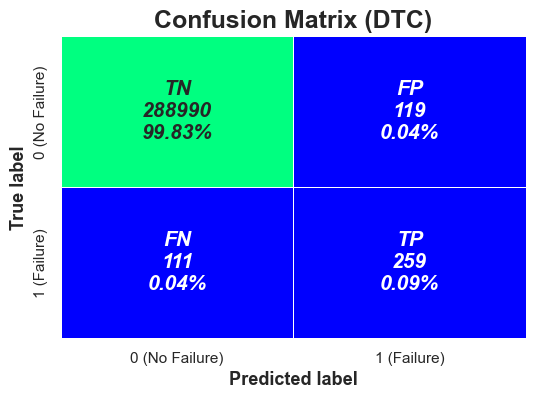

In [50]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (DTC)')

In [51]:
from sklearn.metrics import classification_report
report = classification_report(y_test, dtc_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999616,0.999588,0.999602
1,0.685185,0.700000,0.692513
accuracy,0.999205,0.999205,0.999205
macro avg,0.842401,0.849794,0.846058


In [21]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, dtc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.6969860064585576


In [52]:
styled_report_df.to_excel("report_dtc.xlsx", index=False)

In [53]:
from sklearn.metrics import precision_recall_curve, auc
dtc_pred_prob = dtc.predict_proba(X_test_sc)[:, 1]

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test, dtc_pred_prob)
auc_pr = auc(recall, precision)

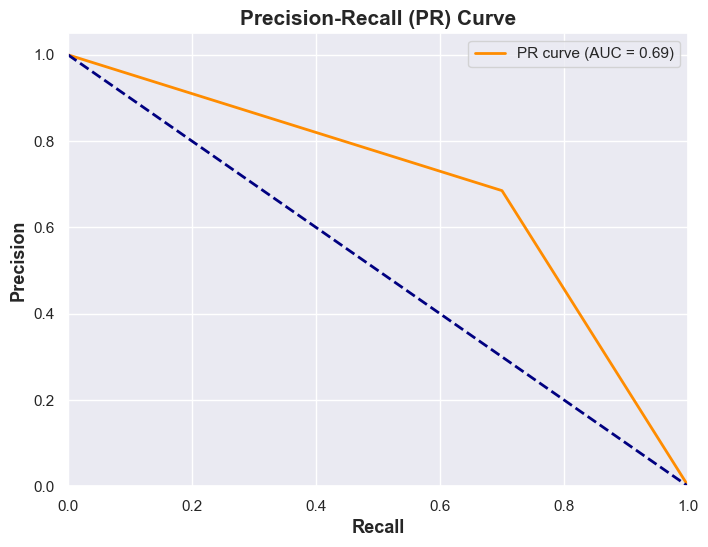

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_dtc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Extra Tree Classification

In [22]:
etc = ExtraTreesClassifier(random_state = 42)
etc.fit(X_train_sc, y_train)
etc_pred = etc.predict(X_test_sc)

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, etc_pred)

In [58]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_etc.JPG',dpi=1000,bbox_inches='tight')

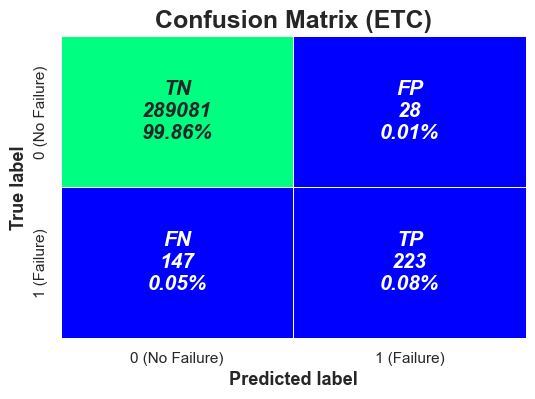

In [59]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (ETC)')

In [60]:
from sklearn.metrics import classification_report
report = classification_report(y_test, etc_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999492,0.999903,0.999697
1,0.888446,0.602703,0.718196
accuracy,0.999395,0.999395,0.999395
macro avg,0.943969,0.801303,0.858947


In [23]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, etc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.6441363373772385


In [61]:
styled_report_df.to_excel("report_etc.xlsx", index=False)

In [62]:
from sklearn.metrics import precision_recall_curve, auc
etc_pred_prob = etc.predict_proba(X_test_sc)[:, 1]

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, etc_pred_prob)
auc_pr = auc(recall, precision)

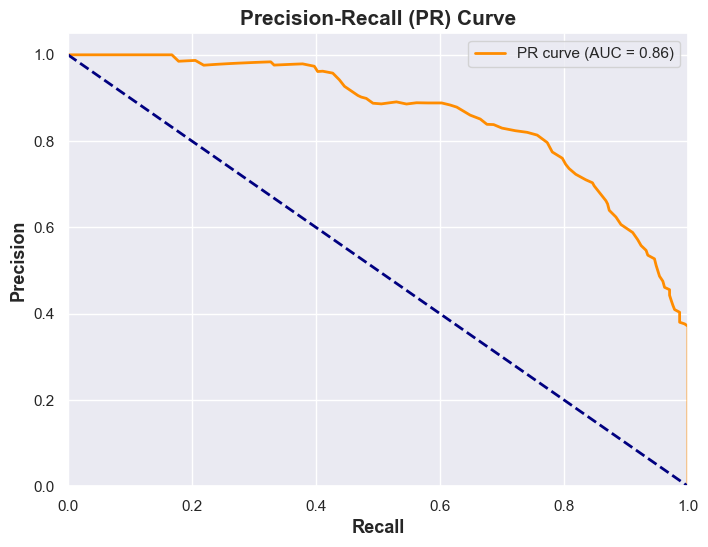

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
#plt.savefig('PR_curve_etc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# KNeighbors Classification

In [24]:
knc = KNeighborsClassifier()
knc.fit(X_train_sc, y_train)
knc_pred = knc.predict(X_test_sc)

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, knc_pred)

In [67]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    


    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_knc.JPG',dpi=1000,bbox_inches='tight')

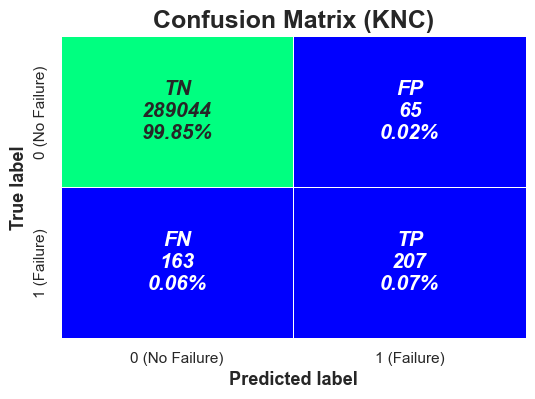

In [68]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (KNC)')

In [69]:
from sklearn.metrics import classification_report
report = classification_report(y_test, knc_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999436,0.999775,0.999606
1,0.761029,0.559459,0.644860
accuracy,0.999212,0.999212,0.999212
macro avg,0.880233,0.779617,0.822233


In [25]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, knc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.5907534246575342


In [70]:
styled_report_df.to_excel("report_knc.xlsx", index=False)

In [71]:
from sklearn.metrics import precision_recall_curve, auc
knc_pred_prob = knc.predict_proba(X_test_sc)[:, 1]

In [72]:
precision, recall, thresholds = precision_recall_curve(y_test, knc_pred_prob)
auc_pr = auc(recall, precision)

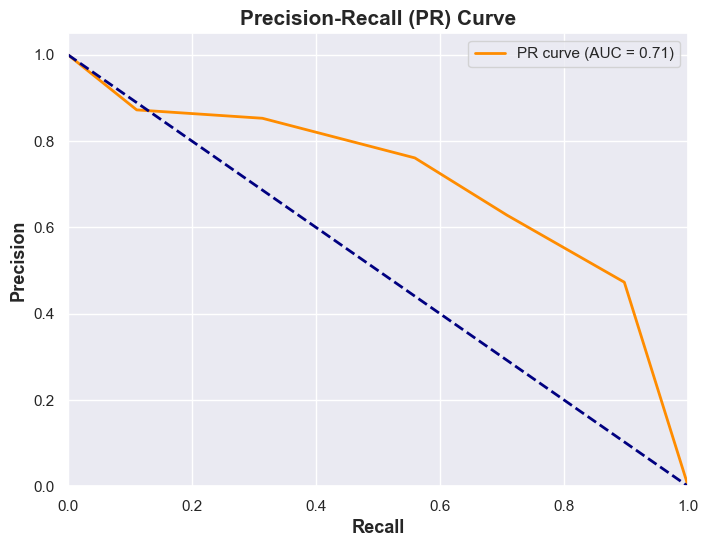

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_knc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# SVM Classification

In [ ]:
from sklearn import svm
svc = svm.SVC(random_state = 42, probability= True)

In [ ]:
svc.fit(X_train_sc, y_train)
svc_pred = svc.predict(X_test_sc)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, svc_pred)

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
   
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_svc.JPG',dpi=1000,bbox_inches='tight')

In [ ]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (SVC)')

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, svc_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

In [ ]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, svc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

In [ ]:
styled_report_df.to_excel("report_svc.xlsx", index=False)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
svc_pred_prob = svc.predict_proba(X_test_sc)[:, 1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, svc_pred_prob)
auc_pr = auc(recall, precision)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_svc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Gradient Boosting Classification

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state = 42)

In [27]:
gbc.fit(X_train_sc, y_train)
gbc_pred = gbc.predict(X_test_sc)

In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, gbc_pred)

In [77]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_gbc.JPG',dpi=1000,bbox_inches='tight')

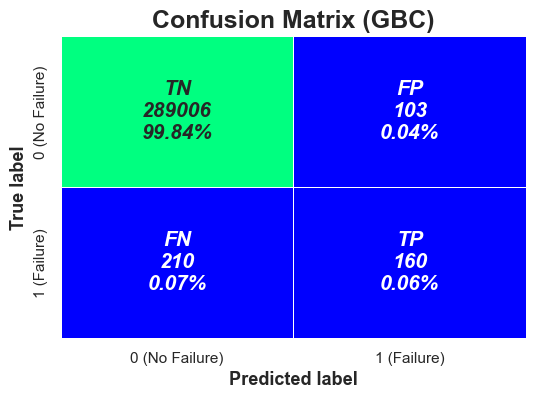

In [78]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (GBC)')

In [79]:
from sklearn.metrics import classification_report
report = classification_report(y_test, gbc_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999274,0.999644,0.999459
1,0.608365,0.432432,0.505529
accuracy,0.998919,0.998919,0.998919
macro avg,0.803819,0.716038,0.752494


In [28]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, gbc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.45897877223178424


In [80]:
styled_report_df.to_excel("report_gbc.xlsx", index=False)

In [81]:
from sklearn.metrics import precision_recall_curve, auc
gbc_pred_prob = gbc.predict_proba(X_test_sc)[:, 1]

In [82]:
precision, recall, thresholds = precision_recall_curve(y_test, gbc_pred_prob)
auc_pr = auc(recall, precision)

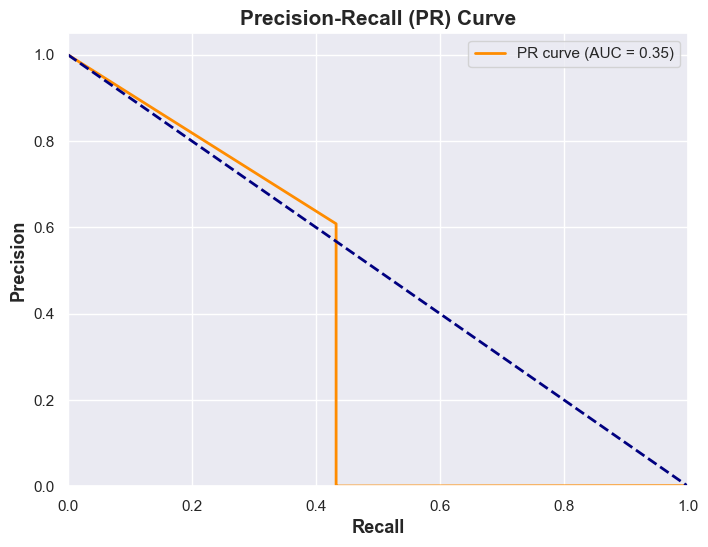

In [83]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_gbc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Hist Gradient Boosting Classification

In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [30]:
hgbc = HistGradientBoostingClassifier(random_state = 42)

In [31]:
hgbc.fit(X_train_sc, y_train)
hgbc_pred = hgbc.predict(X_test_sc)

In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, hgbc_pred)

In [88]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):



    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_hgbc.JPG',dpi=1000,bbox_inches='tight')

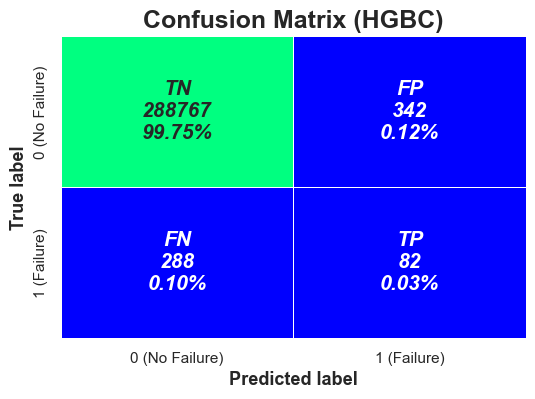

In [89]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (HGBC)')

In [90]:
from sklearn.metrics import classification_report
report = classification_report(y_test, hgbc_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999004,0.998817,0.998910
1,0.193396,0.221622,0.206549
accuracy,0.997824,0.997824,0.997824
macro avg,0.596200,0.610219,0.602730


In [32]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, hgbc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.21533613445378152


In [91]:
styled_report_df.to_excel("report_hgbc.xlsx", index=False)

In [92]:
from sklearn.metrics import precision_recall_curve, auc
hgbc_pred_prob = hgbc.predict_proba(X_test_sc)[:, 1]

In [93]:
precision, recall, thresholds = precision_recall_curve(y_test, hgbc_pred_prob)
auc_pr = auc(recall, precision)

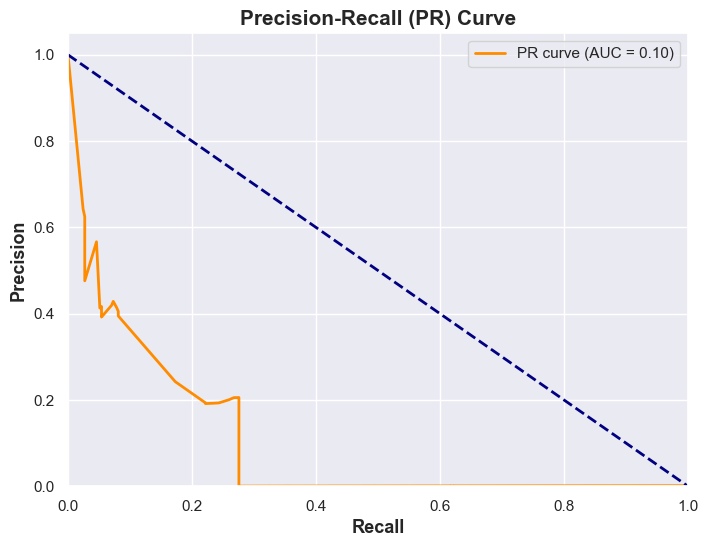

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_hgbc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# AdaBoost Classification

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
abc = AdaBoostClassifier(random_state = 42)

In [35]:
abc.fit(X_train_sc, y_train)
abc_pred = abc.predict(X_test_sc)

In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, abc_pred)

In [99]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_abc.JPG',dpi=1000,bbox_inches='tight')

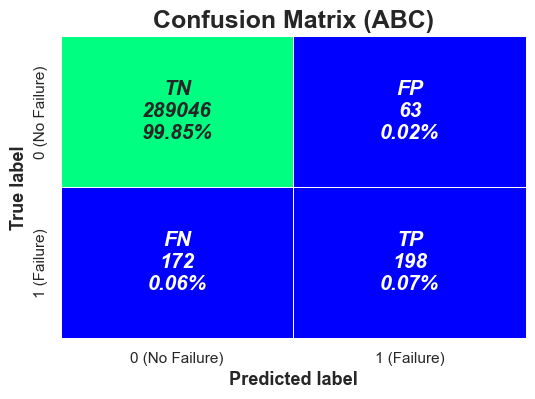

In [100]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (ABC)')

In [101]:
from sklearn.metrics import classification_report
report = classification_report(y_test, abc_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999405,0.999782,0.999594
1,0.758621,0.535135,0.627575
accuracy,0.999188,0.999188,0.999188
macro avg,0.879013,0.767459,0.813584


In [36]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, abc_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.5686387133831132


In [102]:
styled_report_df.to_excel("report_abc.xlsx", index=False)

In [103]:
from sklearn.metrics import precision_recall_curve, auc
abc_pred_prob = abc.predict_proba(X_test_sc)[:, 1]

In [104]:
precision, recall, thresholds = precision_recall_curve(y_test, abc_pred_prob)
auc_pr = auc(recall, precision)

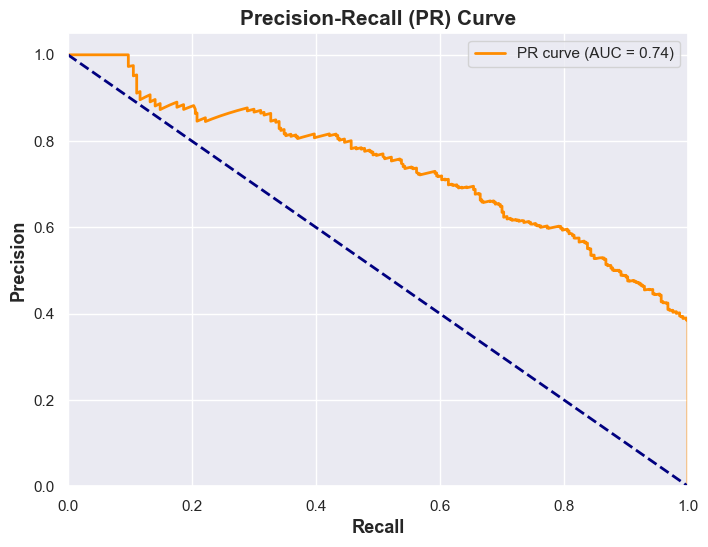

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_abc.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Gaussian Naive Bayes Classification

In [37]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [38]:
gnb.fit(X_train_sc, y_train)
gnb_pred = gnb.predict(X_test_sc)

In [108]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, gnb_pred)

In [109]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    


    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_gnb.JPG',dpi=1000,bbox_inches='tight')

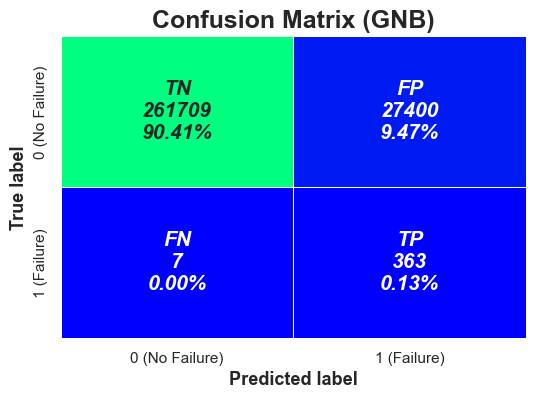

In [110]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (GNB)')

In [111]:
from sklearn.metrics import classification_report
report = classification_report(y_test, gnb_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999973,0.905226,0.950244
1,0.013075,0.981081,0.025806
accuracy,0.905323,0.905323,0.905323
macro avg,0.506524,0.943154,0.488025


In [39]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, gnb_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.062066135485415314


In [112]:
styled_report_df.to_excel("report_gnb.xlsx", index=False)

In [113]:
from sklearn.metrics import precision_recall_curve, auc
gnb_pred_prob = gnb.predict_proba(X_test_sc)[:, 1]

In [114]:
precision, recall, thresholds = precision_recall_curve(y_test, gnb_pred_prob)
auc_pr = auc(recall, precision)

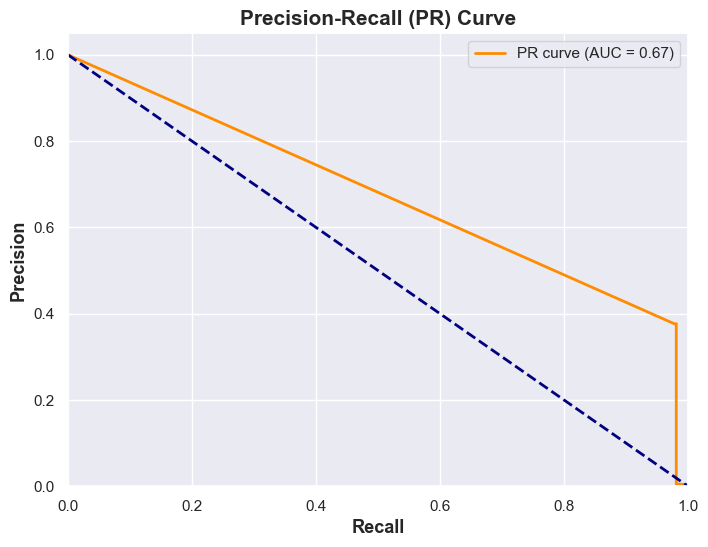

In [115]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_gnb.JPG',dpi=800,bbox_inches='tight')
plt.show()

# XG Boost Classification

In [40]:
import xgboost

In [41]:
xgb = xgboost.XGBClassifier(random_state = 42)

In [42]:
xgb.fit(X_train_sc, y_train)
xgb_pred = xgb.predict(X_test_sc)

In [119]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, xgb_pred)

In [120]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_xgb.JPG',dpi=1000,bbox_inches='tight')

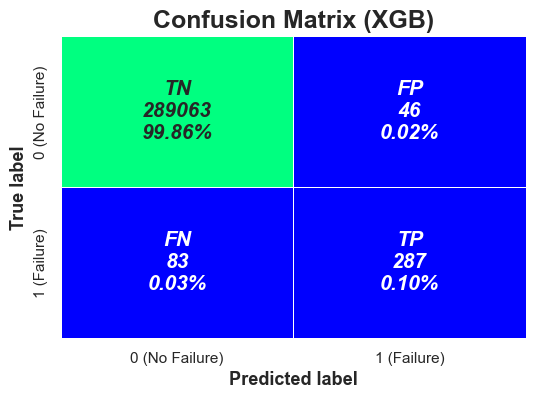

In [121]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (XGB)')

In [122]:
from sklearn.metrics import classification_report
report = classification_report(y_test, xgb_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999713,0.999841,0.999777
1,0.861862,0.775676,0.816501
accuracy,0.999554,0.999554,0.999554
macro avg,0.930787,0.887758,0.908139


In [43]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, xgb_pred, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.7915057915057915


In [123]:
styled_report_df.to_excel("report_xgb.xlsx", index=False)

In [124]:
from sklearn.metrics import precision_recall_curve, auc
xgb_pred_prob = xgb.predict_proba(X_test_sc)[:, 1]

In [125]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred_prob)
auc_pr = auc(recall, precision)

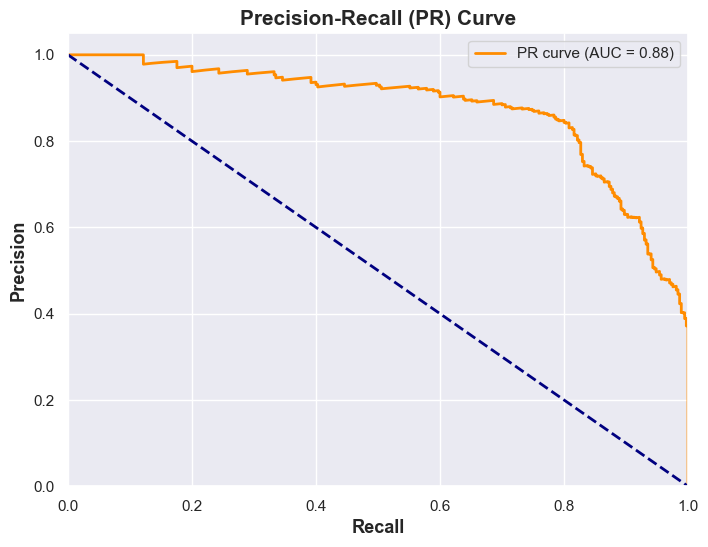

In [126]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_xgb.JPG',dpi=800,bbox_inches='tight')
plt.show()

# Voting Classification (Hard Voting)

In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost

In [45]:
rfc = RandomForestClassifier(random_state = 42)

In [46]:
xgb = xgboost.XGBClassifier(random_state = 42)

In [47]:
hgbc = HistGradientBoostingClassifier(random_state = 42)

In [48]:
etc = ExtraTreesClassifier(random_state = 42)

In [49]:
vc1 = VotingClassifier(estimators= [('rfc', rfc), ('xgb', xgb)], voting='hard')

In [50]:
vc1.fit(X_train_sc, y_train)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))])

In [51]:
vc_pred1 = vc1.predict(X_test_sc)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, vc_pred1)

In [53]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
   
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_vc1.JPG',dpi=1000,bbox_inches='tight')

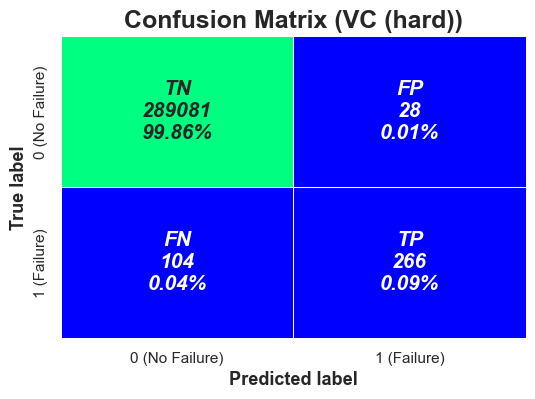

In [54]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (VC (hard))')

In [56]:
from sklearn.metrics import classification_report
report = classification_report(y_test, vc_pred1, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999640,0.999903,0.999772
1,0.904762,0.718919,0.801205
accuracy,0.999544,0.999544,0.999544
macro avg,0.952201,0.859411,0.900488


In [57]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, vc_pred1, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.749718151071026


In [58]:
styled_report_df.to_excel("report_vc1.xlsx", index=False)

In [ ]:
#from sklearn.metrics import precision_recall_curve, auc
#vc_pred_prob1 = vc.predict_proba(X_test_sc)[:, 1]

In [ ]:
#precision, recall, thresholds = precision_recall_curve(y_test, vc_pred_prob)
#auc_pr1 = auc(recall, precision)

In [ ]:
#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision-Recall (PR) Curve')
#plt.legend(loc='lower right')
#plt.show()

# Voting Classification (Soft Voting)

In [59]:
rfc = RandomForestClassifier(random_state = 42)

In [60]:
xgb = xgboost.XGBClassifier(random_state = 42)

In [61]:
hgbc = HistGradientBoostingClassifier(random_state = 42)

In [62]:
etc = ExtraTreesClassifier(random_state = 42)

In [63]:
vc2 = VotingClassifier(estimators= [('rf', rfc), ('xgb', xgb)], voting='soft')

In [64]:
vc2.fit(X_train_sc, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))],
                 voting='soft')

In [65]:
vc_pred2 = vc2.predict(X_test_sc)

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, vc_pred2)

In [67]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=None,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=False,xticklabels=categories,yticklabels=categories, linewidth=0.7, annot_kws={'weight': 'bold', 'style': 'italic', 'size': 15})

    if xyplotlabels:
        plt.ylabel('True label', fontweight = 'bold', fontsize = 13)
        plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 13)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18)
    plt.savefig('Confusion_Matrix_vc2.JPG',dpi=1000,bbox_inches='tight')

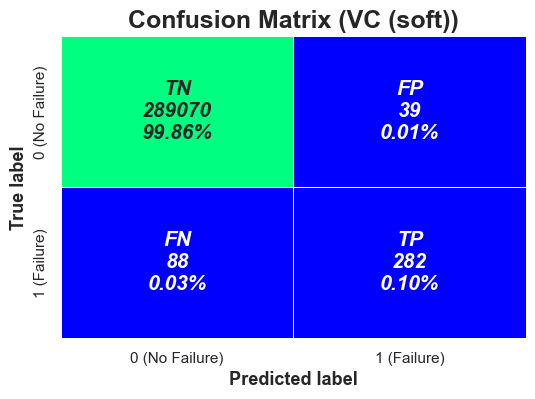

In [68]:
labels = ['TN', 'FP', 'FN', 'TP']
categories = ['0 (No Failure)', '1 (Failure)']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='winter', title = 'Confusion Matrix (VC (soft))')

In [69]:
from sklearn.metrics import classification_report
report = classification_report(y_test, vc_pred2, output_dict = True)
report_df = pd.DataFrame(report).transpose()

def color_map(val):
    if val >= 0.8:
        return 'background-color: lightgreen'
    elif val >= 0.6:
        return 'background-color: yellow'
    elif val >= 0.4:
        return 'background-color: orange'
    else:
        return 'background-color: red'

styled_report_df = report_df.iloc[:-1, :-1].style.applymap(color_map)

styled_report_df

,precision,recall,f1-score
0,0.999696,0.999865,0.999780
1,0.878505,0.762162,0.816208
accuracy,0.999561,0.999561,0.999561
macro avg,0.939100,0.881014,0.907994


In [70]:
from sklearn.metrics import fbeta_score
F2 = fbeta_score(y_test, vc_pred2, beta = 2, labels = [1])
print("F2 Score: {}".format(F2))

F2 Score: 0.7828983897834536


In [71]:
styled_report_df.to_excel("report_vc2.xlsx", index=False)

In [72]:
from sklearn.metrics import precision_recall_curve, auc
vc_pred_prob = vc2.predict_proba(X_test_sc)[:, 1]

In [73]:
precision, recall, thresholds = precision_recall_curve(y_test, vc_pred_prob)
auc_pr2 = auc(recall, precision)

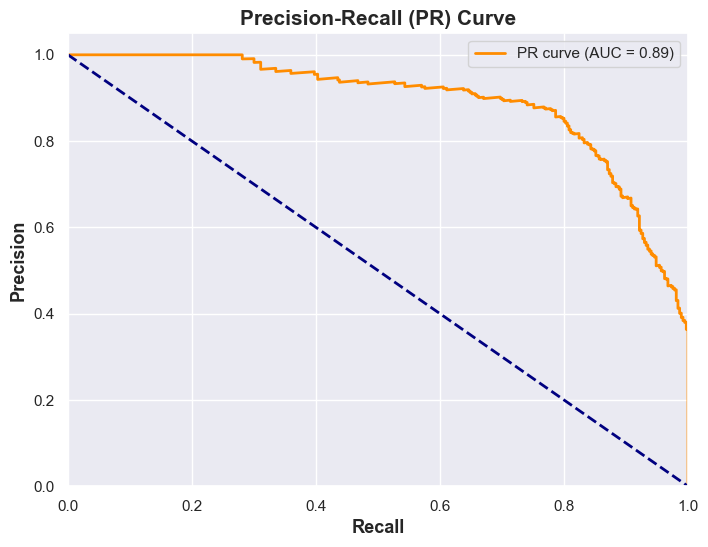

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr2:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight = 'bold', fontsize = 13)
plt.ylabel('Precision', fontweight = 'bold', fontsize = 13)
plt.title('Precision-Recall (PR) Curve', fontweight = 'bold', fontsize = 15)
plt.legend(loc='upper right')
plt.savefig('PR_curve_vc2.JPG',dpi=800,bbox_inches='tight')
plt.show()